In [9]:
#БЛОК 1
#Библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import joblib
from app.preprocessing import *
from app.generate_ratings_elo import *
from app.generate_ratings_intg import *
from app.models import *

warnings.filterwarnings('ignore')

In [10]:
df_player_game = pd.read_csv("data/raw/player_stats.csv", sep=";")
#df = df_player_game.apply(pd.to_numeric, errors='coerce')
df_player_game.replace(0, np.nan, inplace=True)
df_player_game.to_csv('data/raw/player_stats.csv', index=False, sep=";", float_format='%.2f')

In [11]:
#БЛОК 3
#Исходные файлы
df_player_game = pd.read_csv("data/raw/player_stats.csv", sep=";")
df_player_amplua = pd.read_csv("data/raw/players_amplua.csv", sep=";")
df_game_history = pd.read_csv("data/raw/game_history.csv", sep=";")
df_player_age = pd.read_csv("data/raw/players_age.csv", sep=";")
df_plus_minus = pd.read_csv("data/raw/game_plus_minus.csv", sep=";")
goals_and_passes = pd.read_csv("data/raw/goals_and_passes.csv", sep=";")
df_goalkeepers = pd.read_csv("data/raw/goalkeeper_event.csv", sep=";")
df_teams_name = pd.read_csv("data/raw/teams_name_utf8.csv", sep=";")

In [12]:
df_game_history['date'] = pd.to_datetime(df_game_history['date'], format='%d.%m.%Y', errors='coerce').dt.strftime('%Y-%m-%d')

In [13]:
#БЛОК 4
# Удаляем ненужные столбцы
df_player_game.drop(['accurate transmission', 'interception', 'The face-off is won', 'face-off lost', 'ice exits'], axis=1, inplace=True)

In [14]:
#БЛОК 5
#Информация о данных
unique_game_ids = df_player_game['ID game'].nunique()
unique_team_ids = df_player_game['ID team'].nunique()
unique_player_ids = df_player_game['ID player'].nunique()
unique_season_ids = df_game_history['ID season'].nunique()

print("============================================")

df_player_game.info()
df_player_amplua.info()
df_game_history.info()
df_player_age.info()
df_plus_minus.info()
goals_and_passes.info()

print("============================================")

print("Количество уникальных ID game:", unique_game_ids)
print("Количество уникальных ID team:", unique_team_ids)
print("Количество уникальных ID player:", unique_player_ids)
print("Количество уникальных ID season:", unique_season_ids)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74666 entries, 0 to 74665
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 74666 non-null  int64  
 1   ID game            74666 non-null  int64  
 2   ID player          74665 non-null  float64
 3   ID team            74666 non-null  int64  
 4   None               0 non-null      float64
 5   total time on ice  64388 non-null  float64
 6   pucks              27465 non-null  float64
 7   throws by          42661 non-null  float64
 8   a shot on target   47759 non-null  float64
 9   blocked throws     19847 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 5.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID player  10506 non-null  int64
 1   skill      10506 non-null  int64
 2   

In [15]:
#ОБРАБОТКА ДАННЫХ
#БЛОК 6
#Удаляем те игры, в которых ID team = !2
df_player_game = remove_invalid_games(df_player_game)

#Удаление игр с дифицитом данных
process_game_data(df_player_game)

# Удаление лишних игркоков, у которых нет амплуа
process_player_amplua(df_player_amplua, 'data/interim/cleaned_data___.csv')

#Проверка есть ли те игроки, которые были когдато не вратарями и создание compile_stats
#Те игроки, которые раньше были не вратарями, теперь имеют амплуа = 10 или 9
processed_data = check_and_modify_amplua('data/interim/cleaned_data___.csv')

#Удаление тех ID game из таблицы goalkeeper_event, которых нет в таблице compile_stats
filter_goalkeeper_event_by_compile_stats('data/raw/goalkeeper_event.csv', 'compile_stats.csv', 'data/interim/filtered_goalkeeper_event.csv')

#Мерж с таблицей играх вратарей, восстановление вратарей в играх(бывает что их два, а был один, или вообще нету в статистике)
updated_compile_stats = merge_goalkeeper_events('compile_stats.csv', 'data/interim/filtered_goalkeeper_event.csv')

#Добавим возраст к игрокам
updated_compile_stats = add_age_to_players_stats('compile_stats.csv', 'data/raw/players_age.csv')

#Удаляем тех у кого путстые строки кроме вратарей
updated_compile_stats = remove_empty_rows('compile_stats.csv')

#Подготовка таблицы plus_minus для мержа к статиcтике
#Удаление событий, с дифицитом данных
#Валидация данных, таблицы +/-, проверка на пустые ID team, на кол-во игрков в одном событии, а также, чтобы было больше одной
#команды в одном событии
game_plus_minus_cleaned = validation_for_pm(df_plus_minus)
#df_plus_minus = game_plus_minus_cleaned

#Удаление тех ID game которых для которых нету +/- вообще
remove_PL_game('compile_stats.csv', 'data/interim/game_plus_minus_d.csv')

#Сумма, подсчет +/- для игрокв в каждом матче
calculate_plus_minus('data/interim/game_plus_minus_d.csv')

#Добавляем показатель +/-
add_plus_minus('compile_stats.csv', 'data/interim/plus_minus_player_game.csv')

# Проверка анамалий, если игрок по времени не был на льду а p/m есть, то удаляем эту игру
remove_games_with_missing_time('compile_stats.csv')

# Дабавление голов и пассов
add_goals_and_assists('compile_stats.csv', goals_and_passes)

#те игры в которы больше двух вратарей зарегано
#те игры , в которых была замена
filter_goalkeeper_events('compile_stats.csv', 
                         'data/raw/goalkeeper_event.csv', 
                         'data/interim/filtered_goalkeeper_event.csv', 
                         'data/interim/goalkeeper_replace.csv')

del_swap_goalk(
    filtered_event_path='data/interim/filtered_goalkeeper_event.csv', 
    goalkeeper_replace_path='data/interim/goalkeeper_replace.csv', 
    compile_stats_path='compile_stats.csv', 
    output_filtered_event_path='data/interim/filtered_goalkeeper_event_filtered.csv', 
    output_compile_stats_path='compile_stats.csv'
)

#clean_compile_stats('compile_stats.csv')


#Проверка на странные игры, нужно доделать очистку
#clean_problem('compile_stats.csv', 'compile_stats.csv')

#Формирование таблицы goalkeeper_stats , на основе нашей таблици compile_stats
#Создание таблицы goalkeepers и подсчет статитики для вратарей
create_goalkeepers_table('compile_stats.csv', 'data/raw/goals_and_passes.csv', 'goalkeepers_data.csv')

compile_stats = pd.read_csv('compile_stats.csv')
goalsk = pd.read_csv('goalkeepers_data.csv')

# Получение количества уникальных значений в столбцах "ID game" и "ID team"
unique_team_goalk = goalsk['ID team'].nunique()

unique_game_ids = compile_stats['ID game'].nunique()
unique_team_ids = compile_stats['ID team'].nunique()
unique_player_ids = compile_stats['ID player'].nunique()
print("Количество уникальных ID game:", unique_game_ids)
print("Количество уникальных ID team:", unique_team_ids)
print("Количество уникальных ID player:", unique_player_ids)
print("Количество уникальных ID team GOALS:", unique_team_goalk)

Результат работы функции remove_invalid_games:
Количество удаленных игр: 53
Количество оставшихся игр: 2493 

Результат работы функции process_game_data:
Игры, которые будут удалены из-за недостаточного количества игроков с временем на льду или показателей меньше трех:
[99, 100, 101, 103, 444, 700, 850, 6068, 6315, 6353, 6358, 6556, 6557, 6737, 6982, 6984, 7055, 7142, 7145, 7192, 7790, 7882, 7921, 8424, 8805, 8829, 8902, 8967, 8971, 9022, 9043, 9049, 9053, 9070, 9138, 9173, 9209, 9272, 9285, 9286, 9298, 9384, 9632, 9670, 9696, 9743, 9799, 9873, 9875, 10096, 10132, 10267, 10268, 10271, 10299, 10432, 10481, 10558, 10716, 10808, 10810, 10812, 10817, 10825, 10915, 10919, 10959, 11080, 11199]
Количество удаленных игр: 69
Общее количество игр после удаления: 2424 

Результат работы функции check_and_modify_amplua:
Количество игроков, удовлетворяющих условию: 107 

Результат работы функции remove_empty_rows:
Количество удаленных строк: 157 

Результат работы функции validation_for_pm:
Количес

In [16]:
#Вычисление ЭЛО рейтинга и создание ключевого файла где одна строка это все данные за один матч
#БЛОК 7
compile_stats = pd.read_csv('compile_stats.csv')
goalk_df = pd.read_csv('goalkeepers_data.csv')

#Создание файла со статистикой команд за каждый матч
crt_game_stats(compile_stats, goalk_df, df_game_history)

#Поиск оптимального K
optimal_k = find_optimal_k_factor('game_stats_one_r.csv')
print("Оптимальное значение K-фактора:", optimal_k)

#Вычисление ELO рейтинга с найденным K
game_stats = calculate_elo('game_stats_one_r.csv',optimal_k)
game_stats.to_csv('game_stats_one_r.csv', index=False, float_format='%.2f')

KeyboardInterrupt: 

Таблица mean_goalk_stats успешно сохранена в файле mean_stats_goalk.csv
Таблица mean_stats_pl успешно сохранена в файле mean_stats_pl.csv

Общие статистики по показателям для амплуа 10(нападающие):
ID player    5638.442953
amplua         10.000000
time           15.439351
G               0.350878
As              0.245224
TB              1.988220
Shot            2.820206
BT              1.251545
pm             -0.106314
dtype: float64

Общие статистики по показателям для амплуа 9(защитники):
ID player    5362.003854
amplua          9.000000
time           16.497876
G               0.124335
As              0.143671
TB              1.866915
Shot            1.935229
BT              1.479721
pm             -0.184200
dtype: float64

Общие статистики по показателям для амплуа 8(вратари):
ID player    5202.210744
MisG            4.259735
TotalTr        26.270135
ReflSh         83.717644
dtype: float64


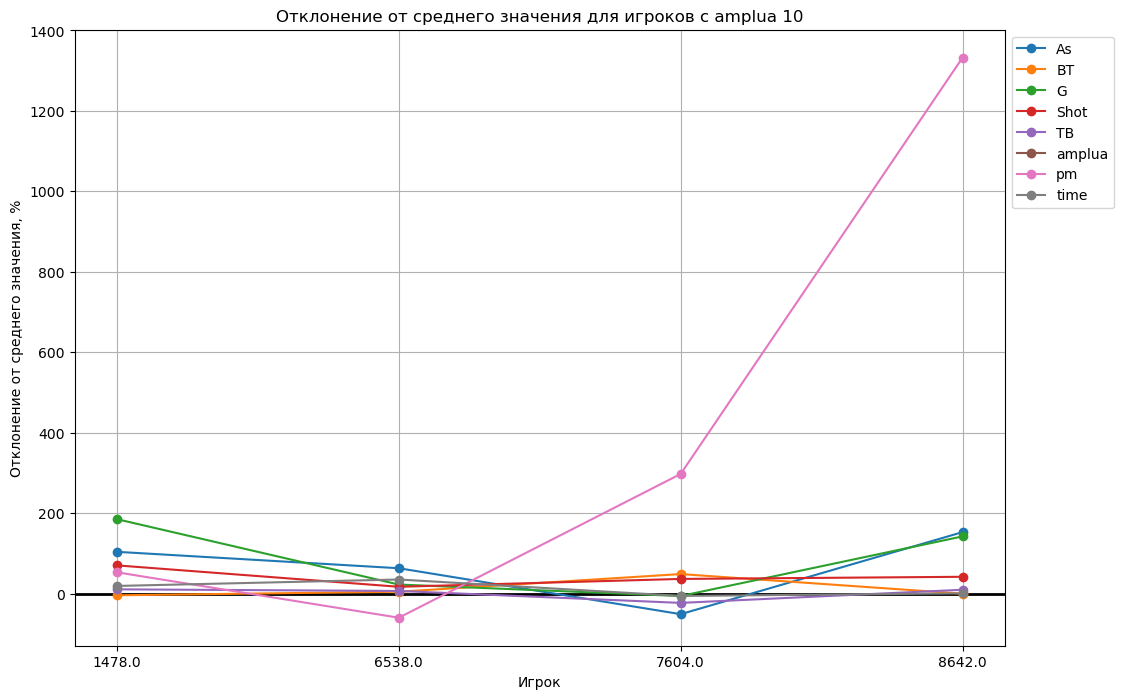

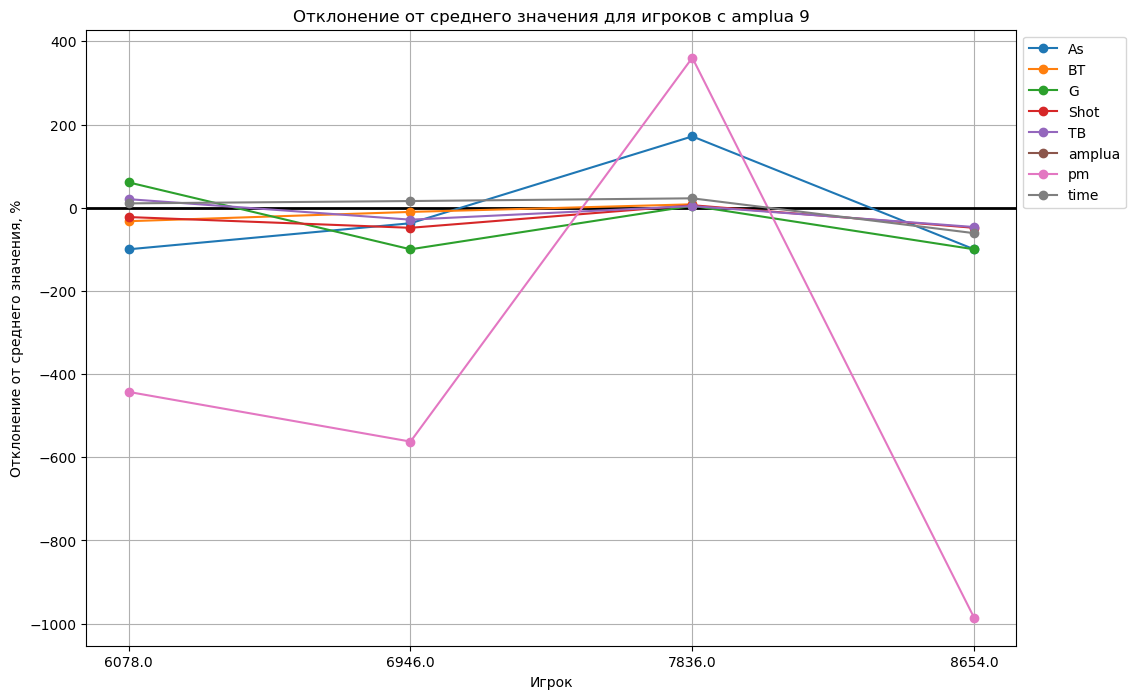

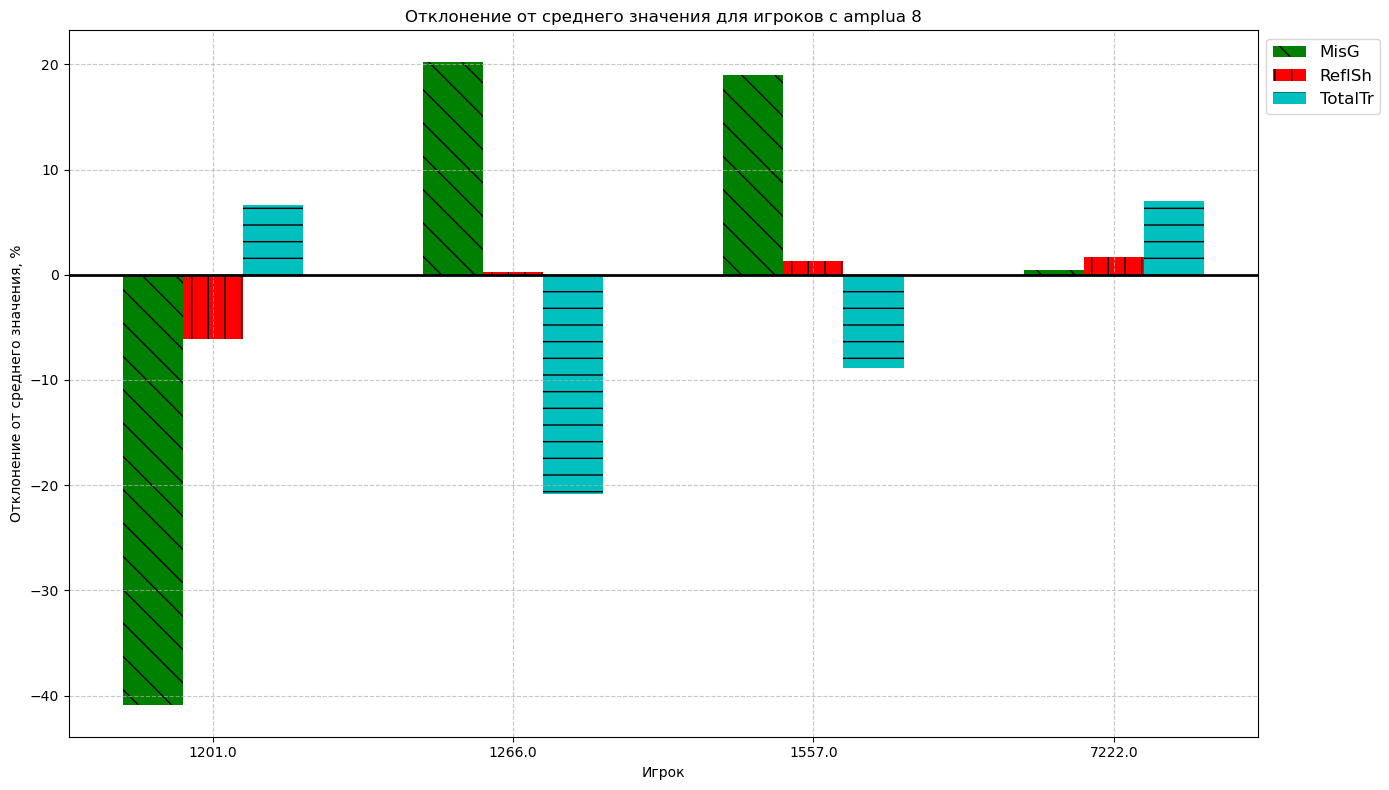

Результаты работы фнукции form_latest_teams:
Количество уникальных команд: 126


KeyboardInterrupt: 

In [12]:
#Вычисление интегрального рейтинга
#БЛОК 8
goalk_data_games = pd.read_csv('goalkeepers_data.csv')

mean_stats_goalk = calculate_mean_goalk_stats(goalk_data_games)
mean_stats_goalk.to_csv('data/processed/rating_last_time/mean_stats_goalk.csv', index=False, float_format='%.2f')

print("Таблица mean_goalk_stats успешно сохранена в файле mean_stats_goalk.csv")

########################################################################################
compile_stats = pd.read_csv('compile_stats.csv')

mean_player_stats = calculate_mean_player_stats(compile_stats)
mean_player_stats.to_csv('data/processed/rating_last_time/mean_stats_pl.csv', index=False, float_format='%.2f')

print("Таблица mean_stats_pl успешно сохранена в файле mean_stats_pl.csv")
########################################################################################
mean_stats_pl = pd.read_csv('data/processed/rating_last_time/mean_stats_pl.csv')

overall_stats_amplua_10, overall_stats_amplua_9 = calculate_overall_stats(mean_stats_pl)

print("\nОбщие статистики по показателям для амплуа 10(нападающие):")
print(overall_stats_amplua_10)

print("\nОбщие статистики по показателям для амплуа 9(защитники):")
print(overall_stats_amplua_9)
#########################################################################################
# Рассчитываем общие статистики для амплуа вратарей
overall_stats_amplua_8 = mean_stats_goalk.mean()

print("\nОбщие статистики по показателям для амплуа 8(вратари):")
print(overall_stats_amplua_8)

###########################################################################################
mean_stats_pl = pd.read_csv('data/processed/rating_last_time/mean_stats_pl.csv')
mean_stats_goalk = pd.read_csv('data/processed/rating_last_time/mean_stats_goalk.csv')

# Построение графиков для игроков с amplua 10
plot_player_deviation(mean_stats_pl, amplua=10, player_ids=[1478, 7604, 6538, 8642])
# Построение графиков для игроков с amplua 9
plot_player_deviation(mean_stats_pl, amplua=9, player_ids=[7836, 6078, 6946, 8654])
###########################################################################################
# Построение графиков для вратарей
plot_goalk_deviation(mean_stats_goalk, num_players=4, random_state=11)
#########################################################################################

######################################################################################################################
mean_stats_pl = pd.read_csv('data/processed/rating_last_time/mean_stats_pl.csv')
mean_stats_goalk = pd.read_csv('data/processed/rating_last_time/mean_stats_goalk.csv')

# Вызов функции для рассчета и добавления отклонений полевых
mean_stats_pl_with_deviations = calculate_and_add_deviations(mean_stats_pl)

# Вызов функции для рассчета и добавления отклонений ВРАТАРЕЙ
mean_stats_pl_with_deviations_goalk = calculate_and_add_deviations_goalk(mean_stats_goalk)

mean_stats_pl_with_deviations.to_csv('data/processed/rating_last_time/mean_stats_deviat_1.csv', index=False, float_format='%.2f')
mean_stats_pl_with_deviations_goalk.to_csv('data/processed/rating_last_time/mean_stats_deviat_GOALK_1.csv', index=False, float_format='%.2f')
#########################################################################################

latest_teams = form_latest_teams(
    compile_stats_path='compile_stats.csv',
    game_history_path='data/raw/game_history.csv',
    output_path='data/processed/rating_last_time/latest_teams.csv'
)

mean_stats_deviat_1 = pd.read_csv('data/processed/rating_last_time/mean_stats_deviat_1.csv')    
output_path=add_weights(mean_stats_deviat_1)
output_path.to_csv('data/processed/rating_last_time/mean_stats_deviat_weights_2.csv', index=False, float_format='%.2f')

mean_stats_deviat_weights_2 = pd.read_csv('data/processed/rating_last_time/mean_stats_deviat_weights_2.csv')
output_path = integral_dev(mean_stats_deviat_weights_2)
output_path.to_csv('data/processed/rating_last_time/integral_rating_pl.csv', index=False, float_format='%.2f')

# Подсчет рейтинга вратаря 
####################################################################################################################
mean_stats_deviat_GOALK = pd.read_csv('data/processed/rating_last_time/mean_stats_deviat_GOALK_1.csv')
mean_stats_deviat_GOALK['integral_dev'] = mean_stats_deviat_GOALK['dev_ReflSh'] * 15
mean_stats_deviat_GOALK = mean_stats_deviat_GOALK.drop(['MisG', 'TotalTr',	'ReflSh', 'dev_MisG', 'dev_ReflSh', 'dev_TotalTr'] , axis=1)
mean_stats_deviat_GOALK.to_csv('data/processed/rating_last_time/rating_goalk.csv', index=False, float_format='%.2f')
####################################################################################################################

team_ratings = calculate_team_ratings_all_time(
    latest_teams_path='data/processed/rating_last_time/latest_teams.csv',
    goalkeepers_data_path='data/processed/rating_last_time/rating_goalk.csv',
    players_data_path='data/processed/rating_last_time/integral_rating_pl.csv',
    output_path='data/processed/rating_last_time/team_ratings.csv'
)

pl_rating_info_result = pl_rating_info(
    latest_teams_path='data/processed/rating_last_time/latest_teams.csv',
    goalkeepers_data_path='data/processed/rating_last_time/rating_goalk.csv',
    players_data_path='data/processed/rating_last_time/integral_rating_pl.csv',
    output_path='data/processed/rating_last_time/pl_rating_info.csv'
)

team_ratings_result = calculate_team_ratings(
    pl_rating_info_path='data/processed/rating_last_time/pl_rating_info.csv',
    output_path='data/processed/rating_last_time/team_bonus.csv'
)

#Расчет рейтингов за все игры
calculate_ratings(
    game_stats_file='compile_stats.csv', 
    game_history_file='data/raw/game_history.csv',
    goalkeepers_file='goalkeepers_data.csv', 
    output_file='data/processed/all/final_ratings.csv', 
    team_output_file='data/processed/all/RATING_TEAM_ALL_TIME.csv'
)

#дОБАВЛЕНИЕ СТРОКИ old_rating
add_old_ratings_to_teams(
    input_file='data/processed/all/RATING_TEAM_ALL_TIME.csv', 
    output_file='data/processed/all/RATING_TEAM_ALL_TIME_with_old_ratings.csv'
)


# Вызов функции с вашими файлами
add_ratings_to_game_stats(
    'data/processed/all/RATING_TEAM_ALL_TIME_with_old_ratings.csv',
    'game_stats_one_r.csv',
    'game_stats_one_r.csv'
)

In [12]:
#Модель машиннного обучения

In [20]:
df = pd.read_csv('game_stats_one_r.csv')

df.info()

print("=========================================================")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID game       1472 non-null   int64  
 1   ID team       1472 non-null   int64  
 2   ID opponent   1472 non-null   int64  
 3   result        1472 non-null   object 
 4   GT            1472 non-null   float64
 5   timeT         1472 non-null   float64
 6   TB_T          1472 non-null   float64
 7   ShotT         1472 non-null   float64
 8   BT_T          1472 non-null   float64
 9   PM_T          1472 non-null   float64
 10  As_T          1472 non-null   float64
 11  GO            1472 non-null   float64
 12  timeO         1472 non-null   float64
 13  TB_O          1472 non-null   float64
 14  ShotO         1472 non-null   float64
 15  BT_O          1472 non-null   float64
 16  PM_O          1472 non-null   float64
 17  As_O          1472 non-null   float64
 18  refl_sh_T     1471 non-null 

Performance of New Models:
LogisticRegression: Accuracy=0.6973, AUC=0.7842
GradientBoosting: Accuracy=0.6930, AUC=0.7419
RandomForest: Accuracy=0.7131, AUC=0.7593


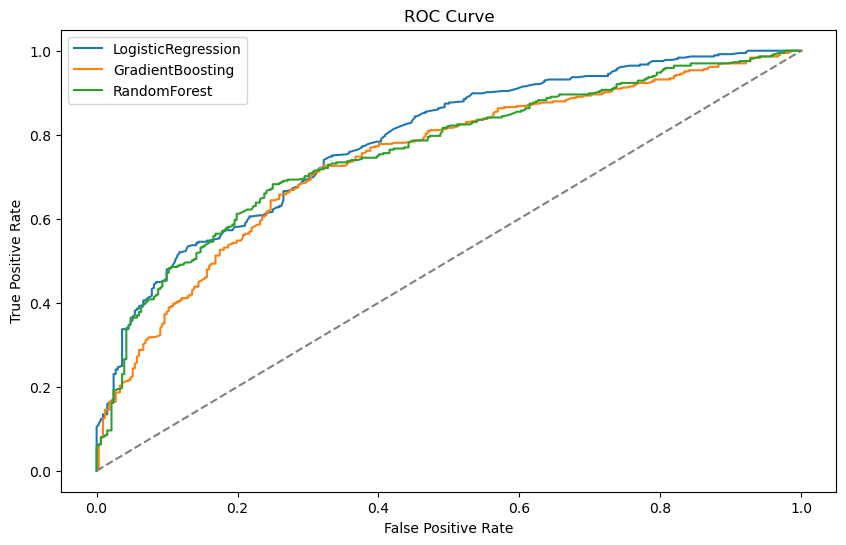

Вероятность победы команды 501 в процентах: 76.38%
Вероятность победы команды 453 в процентах: 23.62%
Вероятность победы команды 38 над командой 453: 72.97%
Вероятность победы команды 38 над командой 208: 72.38%
Вероятность победы команды 38 над командой 12: 70.85%
Вероятность победы команды 38 над командой 110: 70.85%
Вероятность победы команды 38 над командой 4: 68.62%
Вероятность победы команды 38 над командой 445: 66.65%
Вероятность победы команды 38 над командой 399: 65.30%
Вероятность победы команды 38 над командой 46: 64.27%
Вероятность победы команды 38 над командой 92: 63.92%
Вероятность победы команды 38 над командой 545: 62.52%
Вероятность победы команды 38 над командой 447: 62.17%
Вероятность победы команды 38 над командой 61: 60.38%
Вероятность победы команды 38 над командой 406: 60.02%
Вероятность победы команды 38 над командой 53: 58.93%
Вероятность победы команды 38 над командой 505: 58.93%
Вероятность победы команды 38 над командой 400: 57.47%
Вероятность победы команд

['MODEL.pkl']

In [25]:
#БЛОК 9
# нормализации данных
df = pd.read_csv('game_stats_one_r.csv')
matches = scale_and_select_features(df)
#print(matches)

# Удаление строк, где есть хотя бы один NaN
matches = matches.dropna()

# Преобразовать столбец "result"
matches["result"] = matches["result"].map({'W': 1, 'L': -1, 'D': 0})

# вызов функции для получения обучающих и тестовых данных
cutoff_date = '2023-10-28' #обучающие до тестовые после
xTrain, yTrain, xTest, yTest = GetTrainingData(matches, cutoff_date)


# Получение данных
xTrain, yTrain, xTest, yTest = GetTrainingData(matches, cutoff_date)

# Гиперпараметры для GradientBoostingClassifier
gb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200]
}

# Гиперпараметры для RandomForestClassifier
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}
# Задаем сетку гиперпараметров
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1.0, 10.0],
    'solver': ['liblinear', 'saga']
}

# Создание и обучение новых моделей с подбором гиперпараметров
new_models = {
    "LogisticRegression": GridSearchCV(LogisticRegression(solver='sag', max_iter=10000), param_grid, cv=5, scoring='accuracy'),
    "GradientBoosting": GridSearchCV(GradientBoostingClassifier(), gb_param_grid, cv=5, scoring='accuracy'),
    "RandomForest": GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='accuracy')
}

new_results = {}
for name, model in new_models.items():
    model.fit(xTrain, yTrain)
    y_pred = model.predict(xTest)
    y_pred_proba = model.predict_proba(xTest)[:, 1]  # Вероятность победы команды 1
    
    accuracy = accuracy_score(yTest, y_pred)
    auc = roc_auc_score(yTest, y_pred_proba)
    
    new_results[name] = {"Accuracy": accuracy, "AUC": auc}

# Вывод результатов новых моделей
print("Performance of New Models:")
for name, result in new_results.items():
    print(f"{name}: Accuracy={result['Accuracy']:.4f}, AUC={result['AUC']:.4f}")

# Графики ROC-кривых для новых моделей
plt.figure(figsize=(10, 6))
for name, model in new_models.items():
    y_pred_proba = model.predict_proba(xTest)[:, 1]
    fpr, tpr, _ = roc_curve(yTest, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


#ПРИМЕР: проверка шансов на победу двух комапнд
# Пример ID команд
team1_id = 501
team2_id = 453

# Получение вероятности победы команды 1
win_probability_lr1 = get_team_win_probability(new_models, matches, team1_id, team2_id)
win_probability_lr2 = get_team_win_probability(new_models, matches, team2_id, team1_id)

# Получение вероятностей
probabilities = [win_probability_lr1, win_probability_lr2]

# Нормализация вероятностей
normalized_probs = normalize_probabilities(probabilities)

# Вывод процентов
for team_id, prob in zip([team1_id, team2_id], normalized_probs):
    print(f"Вероятность победы команды {team_id} в процентах: {prob * 100:.2f}%")

#ПРИМЕР: проверки шансов на победы КОМАНДЫ против ВСЕХ остальных команд
team_id = 38  # ID вашей команды
win_probabilities = get_team_win_probabilities(new_models, team_id, matches)

# Сортировка вероятностей по убыванию
sorted_win_probabilities = sorted(win_probabilities.items(), key=lambda x: x[1], reverse=True)

# Вывод вероятностей победы вашей команды над каждой из других команд, отсортированных по вероятности
for opp_team_id, prob in sorted_win_probabilities:
    print(f"Вероятность победы команды {team_id} над командой {opp_team_id}: {prob * 100:.2f}%")

# Сохранение обученной модели
joblib.dump(new_models["LogisticRegression"], 'saved_models/MODEL.pkl')

In [ ]:
#Создать таблицу актуальных рейтингов

In [42]:
#БЛОК 10
#делаем таблицу ЭЛО
def print_elo_ratings_with_division_and_games(game_stats):
    team_data = []

    team_ids = game_stats['ID team'].unique()

    # Для каждой команды находим ее последний ELO рейтинг и количество сыгранных матчей
    for team_id in team_ids:
        # Выбираем записи только для текущей команды
        team_matches = game_stats[(game_stats['ID team'] == team_id) | (game_stats['ID opponent'] == team_id)]

        # Выбираем запись с последним матчем для текущей команды
        last_match = game_stats[game_stats['ID team'] == team_id].iloc[-1]

        # Получаем ELO рейтинг и номер дивизиона для текущей команды
        elo_rating = last_match['ELO']
        division = last_match['division']

        # Получаем количество сыгранных матчей для текущей команды
        num_matches = len(team_matches)

        # Добавляем данные о команде в список
        team_data.append({'ID team': team_id, 'ELO': elo_rating, 'Division': division, 'Matches': num_matches})

    # Создаем DataFrame из списка данных о командах
    elo_division_games_df = pd.DataFrame(team_data)

    # Сортируем DataFrame по ELO рейтингу
    elo_division_games_df = elo_division_games_df.sort_values(by='ELO')

    elo_division_games_df.to_csv('data/interim/ELO_df.csv', index=False)
    
game_stats = pd.read_csv('game_stats_one_r.csv')
print_elo_ratings_with_division_and_games(game_stats)

itog_dev_sum = pd.read_csv('data/processed/rating_last_time/team_bonus.csv')
team_ratings = pd.read_csv('data/interim/ELO_df.csv')
teams_name = pd.read_csv('data/raw/teams_name_utf8.csv')

# Объединяем таблицы по ID team
team_ratings = team_ratings.merge(itog_dev_sum[['ID team', 'PL_RATING']], on='ID team')

team_ratings.insert(2, 'ELO', team_ratings.pop('ELO'))

# Сортировка по 'Division' (возрастание) и 'ELO' (убывание)
team_ratings = team_ratings.sort_values(by=['Division', 'ELO'], ascending=[True, False])

#team_ratings = team_ratings.sort_values(by='Division')

team_ratings = team_ratings.merge(teams_name[['ID team', 'TEAM_NAME']], on='ID team')

# Удаление столбцов "солбики" и "ID team"
#team_ratings.drop(columns=['ID team'], inplace=True)

new_order = ['ID team', 'TEAM_NAME', 'Division', 'ELO', 'PL_RATING', 'Matches']

team_ratings = team_ratings[new_order]

#ТУТ БУДЕТ ТАБЛИЦА КОТОРАЯ ХРАНИТ В СЕБЕ АКТУЛЬНУЮ ИНФОРМАЦИЮ О КОМАНДАХ
team_ratings.to_csv('team_ratings_merge.csv', index=False)
######################################################################################################################################################

In [43]:
#Распределение команд

In [44]:
#БЛОК 11
# Загрузка данных из файла game_stats_one_r_with_ratings.csv
game_stats = pd.read_csv("game_stats_one_r.csv")

# Получение уникальных значений в столбце ID season
unique_season_ids = game_stats['ID season'].unique()

# Вывод уникальных значений
print("Уникальные значения в столбце ID season:")
print(unique_season_ids)

Уникальные значения в столбце ID season:
[67. 60. 68. 70. 63. 74. 75. 73. 78. 84. 82. 85. 86.]


In [45]:
#БЛОК 12
season = 73
game_before_season, unique_teams = process_season_data(season)

print("Уникальные команды и их дивизионы в текущем сезоне:", unique_teams)

Уникальные команды и их дивизионы в текущем сезоне:       ID team  division
173       411         2
174       214         1
175       176         3
213       333         0
214       189         0
216       449         3
217       269         1
301        15         0
302       409         1
303       404         2
338       452         0
339       401         3
343       329         1
345       448         2
973       451         3
974       335         1
975       402         1
983        44         1
985       215         3
986        12         0
995       332         2
996       438         2
1001      431         3
303       439         2
341        23         1


In [46]:
#КОД ДЛЯ ОЦЕНИВАНИЯ РАСПРЕДЕЛЕНЯИ КОМАНД ПО ДИВЗИИОНАМ

In [50]:
#БЛОК 13
# тут идет оценка распределния ЛИГИ
season = 73

game_before_season, unique_teams = process_season_data(season)

game_before_season.fillna(0, inplace=True)  # Изменение данных на месте
game_before_season.replace([np.inf, -np.inf], 0, inplace=True)  # Изменение данных на месте

matches = scale_and_select_features(game_before_season)
matches["result"] = matches["result"].map({'W': 1, 'L': -1, 'D': 0})
# Преобразование данных в структуру division_teams
division_teams = unique_teams.groupby('division')['ID team'].apply(list).to_dict()

match_results_df = simulate_all_matches(division_teams)
average_highest_probabilities = calculate_average_highest_probabilities(match_results_df)

# Сохранение результатов в CSV файл
match_results_df.to_csv('data/interim/simulated_matches.csv', index=False)

# Вывод количества команд и количества матчей для каждого дивизиона
for division, teams in division_teams.items():
    num_teams = len(teams)
    num_matches = num_teams * (num_teams - 1) // 2  # Количество уникальных матчей
    print(f"Дивизион: {division}, Количество команд: {num_teams}, Количество матчей: {num_matches}")

# Вывод среднего значения наибольших вероятностей для каждого дивизиона
print("Среднее значение наибольших вероятностей для каждого дивизиона:")
print(average_highest_probabilities)


Дивизион: 0, Количество команд: 5, Количество матчей: 10
Дивизион: 1, Количество команд: 8, Количество матчей: 28
Дивизион: 2, Количество команд: 6, Количество матчей: 15
Дивизион: 3, Количество команд: 6, Количество матчей: 15
Среднее значение наибольших вероятностей для каждого дивизиона:
division
0    85.186994
1    78.470262
2    84.023802
3    67.874406
dtype: float64


In [51]:
#БЛОК 14
#Тут мы пытаемся ранжировать команды лучше чем лига, последние два аргумента это кол-во дивизонов и мин. кол-во команд в одном дивизионе
rank_teams(unique_teams, 'MODEL.pkl', num_divisions=4, min_teams_per_division=5)
#Эта функция создает файл team_rangirov в котором команды распределены, и снизу мы даем оценку этому распределению

Количество уникальных команд: 25


In [52]:
#БЛОК 15
# Загрузка данных из team_rangirov.csv
team_rangirov = pd.read_csv('team_rangirov.csv')

# Преобразование данных в структуру division_teams
division_teams = team_rangirov.groupby('division')['ID team'].apply(list).to_dict()

# Выполнение симуляции матчей и вычисление средних наибольших вероятностей
match_results_df = simulate_all_matches(division_teams)
average_highest_probabilities = calculate_average_highest_probabilities(match_results_df)

# Сохранение результатовл
match_results_df.to_csv('data/interim/simulated_matches.csv', index=False)

# Вывод кол-ва команд и количества матчей для каждого дивизиона
for division, teams in division_teams.items():
    num_teams = len(teams)
    num_matches = num_teams * (num_teams - 1) // 2  # Количество уникальных матчей
    print(f"Дивизион: {division}, Количество команд: {num_teams}, Количество матчей: {num_matches}")

# Вывод среднего значения наибольших вероятностей для каждого дивизиона
print("Среднее значение наибольших вероятностей для каждого дивизиона:")
print(average_highest_probabilities)


Дивизион: Division 1, Количество команд: 7, Количество матчей: 21
Дивизион: Division 2, Количество команд: 6, Количество матчей: 15
Дивизион: Division 3, Количество команд: 6, Количество матчей: 15
Дивизион: Division 4, Количество команд: 6, Количество матчей: 15
Среднее значение наибольших вероятностей для каждого дивизиона:
division
Division 1    70.960555
Division 2    62.542455
Division 3    55.202261
Division 4    69.991397
dtype: float64


In [ ]:
#Ранжирование тех команд которые сами хотим распределить, тоесть создали сами таблицу с командами, например которые будут в новом дивизионе

In [ ]:
#тут мы создали табилцу с командами  и их последними двизионами team_for_rangir, и ранжируем их нашим алгоритмом

In [55]:
#БЛОК 16
unique_teams = pd.read_excel('team_for_rangir.xlsx') #"ручная" таблица
data_team = pd.read_csv('game_stats_one_r.csv') # файл со статитстикой

data_team.fillna(0, inplace=True)  # Изменение данных на месте
data_team.replace([np.inf, -np.inf], 0, inplace=True)  # Изменение данных на месте

matches = scale_and_select_features(data_team)
matches["result"] = matches["result"].map({'W': 1, 'L': -1, 'D': 0})
######################################################################################
#Вызов функции для автоматического распределения 
rank_teams(unique_teams, 'MODEL.pkl', num_divisions=2, min_teams_per_division=4)
######################################################################################
team_rangirov = pd.read_csv('team_rangirov.csv')

# Преобразование данных в структуру division_teams
division_teams = team_rangirov.groupby('division')['ID team'].apply(list).to_dict()

match_results_df = simulate_all_matches(division_teams)
average_highest_probabilities = calculate_average_highest_probabilities(match_results_df)

# Сохранение результатов в CSV файл
match_results_df.to_csv('data/interim/simulated_matches.csv', index=False)

# Вывод количества команд и количества матчей для каждого дивизиона
for division, teams in division_teams.items():
    num_teams = len(teams)
    num_matches = num_teams * (num_teams - 1) // 2  # Количество уникальных матчей
    print(f"Дивизион: {division}, Количество команд: {num_teams}, Количество матчей: {num_matches}")

# Вывод среднего значения наибольших вероятностей для каждого дивизиона
print("Среднее значение наибольших вероятностей для каждого дивизиона:")
print(average_highest_probabilities)


Количество уникальных команд: 8
Дивизион: Division 1, Количество команд: 4, Количество матчей: 6
Дивизион: Division 2, Количество команд: 4, Количество матчей: 6
Среднее значение наибольших вероятностей для каждого дивизиона:
division
Division 1    65.10096
Division 2    85.63378
dtype: float64


In [56]:
# тут мы просто оцениваем наше РУЧНОЕ ранжирование, тоесть если сами руками распределлил команды, и хотип узнать насколько хорошо

In [57]:
unique_teams = pd.read_excel('team_for_rangir.xlsx') # "ручная" таблица
data_team = pd.read_csv('game_stats_one_r.csv')

data_team.fillna(0, inplace=True)  # Изменение данных на месте
data_team.replace([np.inf, -np.inf], 0, inplace=True)  # Изменение данных на месте

matches = scale_and_select_features(data_team)
matches["result"] = matches["result"].map({'W': 1, 'L': -1, 'D': 0})

# Преобразование данных в структуру division_teams
division_teams = unique_teams.groupby('division')['ID team'].apply(list).to_dict()

match_results_df = simulate_all_matches(division_teams)
average_highest_probabilities = calculate_average_highest_probabilities(match_results_df)

# Сохранение результатов в CSV файл
match_results_df.to_csv('data/interim/simulated_matches.csv', index=False)

# Вывод количества команд и количества матчей для каждого дивизиона
for division, teams in division_teams.items():
    num_teams = len(teams)
    num_matches = num_teams * (num_teams - 1) // 2  # Количество уникальных матчей
    print(f"Дивизион: {division}, Количество команд: {num_teams}, Количество матчей: {num_matches}")

# Вывод среднего значения наибольших вероятностей для каждого дивизиона
print("Среднее значение наибольших вероятностей для каждого дивизиона:")
print(average_highest_probabilities)


Дивизион: 0, Количество команд: 4, Количество матчей: 6
Дивизион: 2, Количество команд: 4, Количество матчей: 6
Среднее значение наибольших вероятностей для каждого дивизиона:
division
0    82.539202
2    94.457441
dtype: float64
